## Задание. Создать нейронную сеть со следующей структурой


Network( <br/>
    (hidden): Linear(in_features=784, out_features=256, bias=True) <br/>
    (output): Linear(in_features=256, out_features=10, bias=True) <br/>
    (sigmoid): Sigmoid() <br/>
    (softmax): Softmax(dim=1) <br/>
)


Подключить необходимые библиотеки: torch, numpy и matplotlib.pyplot:

In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

Создать класс и описать в нём необходимую нам структуру:

In [110]:
import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()         
        self.hidden = nn.Linear(784, 256)            
        self.output = nn.Linear(256, 10)            
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(1)           

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = self.softmax(x)
        return x

model = Network()

Создадим экземпляр класса и выведем его на печать, чтобы проверить, что наша архитектура совпадает с заданной:

In [111]:
print(model) ## WRITE YOUR CODE HERE

Network(
  (hidden): Linear(in_features=784, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


Будем использовать набор данных MNIST. Применим трансформации перевода в тензор и нормализации с параметрами (0.5):

In [112]:
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Зададим функцию view_classify для более удобного вывода результатов на экран:

In [113]:
def view_classify(img, ps, version="MNIST"):
    '''
    Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

Будем итерироваться по тренировочному множеству и выведем результат работы нейронной сети на экран:

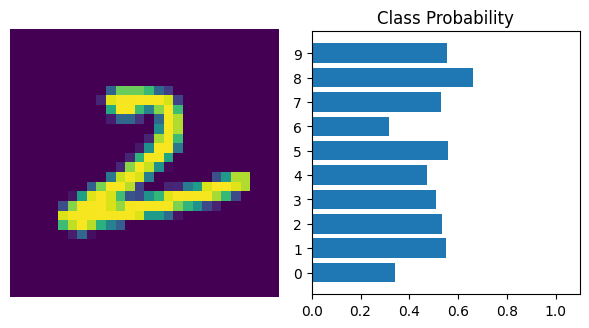

In [114]:
# Grab some data
images = next(iter(trainloader))[0]

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels)
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size

# Forward pass through the network
img_idx = 0
ps = model.forward(images[img_idx,:])

img = images[img_idx]
view_classify(img.view(1, 28, 28), ps)

Вопрос: почему получилось такое распределение вероятностей предсказаний классов?

Ответ: веса в этой нейронной сети задавались случайным образом, то есть сеть никак не обучалась.

## Обучение нейронной сети

Суть обучения нейронной сети заключается в подборе (посредством постепенного изменения) весов и bias-векторов (параметров сети) таким образом, чтобы разница между выходом нейронной сети и целевым значением была минимальна.

Для этого строится **функция потерь (Loss function)** - функция, которая оценивает <<расстояние>> между значением, которое получилось на выходе нейронной сети (Prediction), и заранее заданным значением (Labels).

Чтобы минимизировать функцию потерь, используется метод обратного распространения ошибки (Backpropagation), суть которого заключается в нахождении минимума функции потерь через вычисление её градиента, который в свою очередь зависит только от входных данных (поэтому обратное распространение).

Метод обратного распространения ошибки включает в себя следующие шаги:
* Forward Pass (FP) — прямое распространение сигнала от входа к выходам (без которого не получить вычисленные значения в графе);
* Backward Pass (BP) — расчёт величины градиента от выхода ко входам;
* обновление весов в зависимости от величины градиента (скорость обучения или learning rate).

<img src= https://www.researchgate.net/publication/341817070/figure/fig3/AS:897824409526282@1591069428935/Schematic-of-backpropagation-In-the-forward-pass-of-a-simple-neural-network-an-input.ppm>

Существует несколько реализаций метода обратного распространения ошибки:
- стохастического градиентного спуска (Stochastic Gradient Descent, SGD);
- пакетного градиентного спуска (Mini-Bath Gradient Descent, MBGD).

Итого, один цикл обучения включает:
- загрузку данных (Features);
- один проход данных сквозь нейронную сеть (Neural Network);
- получение предсказаний нейронной сети (Prediction);
- выгрузка значений, которые соответствуют данным (Labels);
- построение функции потерь (Loss) от двух параметров Prediction и Loss;
- применение метода обратного распространения ошибки (Backpropagation).

<img src=https://galaxyinferno.com/wp-content/uploads/2021/08/Slide3.jpg>

Например, внутри одной эпохи обучения двухслойной неронной сети необходимо выполнять следующие действия:
- предобработать данные;
- умножить их на веса;
- применить функцию активации;
- снова умножить на веса;
- вычислить значение функции потерь;
- вычислить градиент функции потерь по весам;
- обновить веса;
- оценить точность.

Нейронная сеть в процессе **обучения** последовательно обрабатывает все объекты из обучающей выборки.
Предъявление нейронной сети всех объектов обучающей выборки по одному разу называется **эпохой обучения**.

Обучающую выборку разделяют на две части: непосредственно использующуюся для обучения (train data) и тестовую (test data) или валидационную (validation data). На тестовых данных каждую эпоху происходит оценка качества обучения. Стратегия разделения на train и test/validation подвыборки может быть произвольной, но при разделении следует заботиться о том, чтобы эти подвыборки были "похожи".

Обучение модели — итеративный процесс. На каждой итерции модель получает входные данные, дает предсказание на выходе, вычисляет значение функции потерь (loss), вычисляет производные функции потерь по параметрам и подстраивает параметры, используя градиентный спуск. Для более детального рассмотрения этого процесса рекомендуем посмотреть [видео об обратном распространении ошибки от 3Blue1Brown](https://www.youtube.com/watch?v=tIeHLnjs5U8).

[Плейлист с видео о нейронных сетях от 3Blue1Brown с озвучкой на русском](https://www.youtube.com/playlist?list=PLfdZ2TeaMzfzlpZ60rbaYU_epH5XPNbWU).

## Гиперпараметры

Гиперпараметры — это задаваемые разработчиком параметры, которые позволяют управлять процессом обучения. Различные значения гиперпараметров могут влиять на обучение модели и скорость сходимости ([здесь](https://pytorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html) можно почитать подробнее про подбор гиперпараметров).

Определим следующие гиперпараметры процедуры обучения:
* **количество эпох** (`num_epochs`) — количество итераций обучения по всему набору данных;
* **размер батча** (`batch_size`) — количество образцов, передаваемых в сеть для обновления параметров;
* **скорость обучения** (`learning_rate`) — коэффициент, определяющий, насколько сильно нужно обновлять параметры модели на каждом батче. Малые значения приводят к долгому обучению, в то время как большие значения могут приводить к непредсказуемому поведению во время обучения.

In [115]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

## Функция потерь (Loss function)

При получении некоторых обучающих данных наша необученная сеть, скорее всего, не даст правильного ответа. Функция потерь измеряет степень различия между значениями на выходе сети и целевыми значениями. Именно функцию потерь мы и хотим минимизировать во время обучения. Для вычисления функции потерь нужно получить предсказание модели, передав ей на вход пример из данных, и сравнить его с истинным значением целевой переменной.

Наиболее часто применяемыми функциями потерь являются [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) (Mean Square Error) для задач регрессии и [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) для задач класиификации.


Мы будем передавать выходы модели (логиты) в `nn.CrossEntropyLoss`, которая будет их нормализовывать и вычислять ошибку предсказания.

In [116]:
criterion = nn.CrossEntropyLoss()

## Оптимизатор (Optimizer)

Оптимизация — это процесс подстройки параметров модели для уменьшения ошибки на каждом шаге обучения. От **алгоритма оптимизации** зависит то, как этот процесс будет выполняться. Здесь мы будем использовать стохастический градиентный спуск (Stochastic Gradient Descent, SGD). Однако в PyTorch реализовано еще [множество других алгоритмов оптимизации](https://pytorch.org/docs/stable/optim.html#algorithms), таких как Adam и RMSProp, и они могут работать лучше или хуже для разных видов моделей и данных.

Вся логика оптимизации заключена в объекте `optimizer`. Мы инициализируем оптимизатор, передавая ему параметры модели, которые требуется обучать (`model.parameters()`), а также гиперпараметр скорости обучения (`learning_rate`).

In [117]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Цикл обучения

Внутри цикла обучения, оптимизация производится за три шага:
1. Вызов `optimizer.zero_grad()`, чтобы сбросить градиенты параметров модели. По умолчанию градиенты суммируются, и во избежание повторного вычисления их необходимо явно обнулять на каждой итерации;
2. Обратное распространение ошибки предсказания с помощью вызова `loss.backward()`. PyTorch вычислит градиенты функции потерь относительно каждого обучаемого параметра;
3. Когда у нас есть градиенты, мы вызываем `optimizer.step()`, чтобы подстроить обучаемые параметры с учетом градиентов, посчитанных при обратном распространении, согласно алгоритму оптимизации.

Итого, в цикле обучения в следующем порядке должны идти строчки:  <br>
optimizer.zero_grad() <br>
loss.backward()  <br>
optimizer.step()  <br>

Наиболее просто полный процесс обучения нейронной сети может быть представлен следующим кодом:

In [118]:
from torch import optim

model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))


num_epochs = 5
learning_rate = 0.003

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for e in range(num_epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)

        # Training pass
        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.9189824459395175
Training loss: 0.871666183444991
Training loss: 0.5423966927855
Training loss: 0.44197430830202633
Training loss: 0.39191542711974714


Посмотрим на вероятности предсказанных классов после обучения нейронной сети:

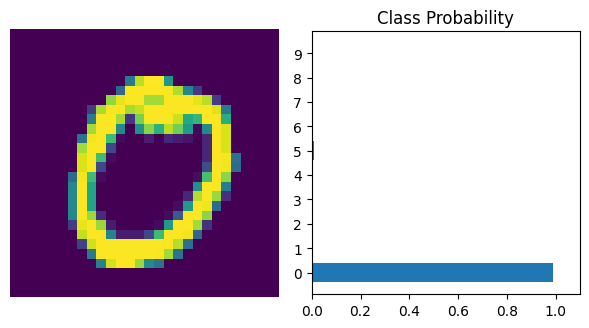

In [119]:
%matplotlib inline

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
view_classify(img.view(1, 28, 28), ps)

Видим, что нейронная сеть уже научилась распознавать цифры с достаточно большой вероятностью.

# Пример нейронной сети для решения задачи классификации на наборе данных MNIST

Шаг 1. Подгружаем необходимые библиотеки:

In [120]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from IPython.display import clear_output
from torch.utils.data import DataLoader

Шаг 2. Выбираем гиперпараметры для нейронной сети:

In [121]:
num_epochs = 10
batch_size = 64
learning_rate = 1e-3

Шаг 3. Загружаем набор данных MNIST:

In [122]:
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [123]:
example_data = torch.cat([transforms.functional.pil_to_tensor(trainset[i][0]) for i in range(60000)])

Шаг 4. Посмотрим на основные параметры данных:

In [124]:
print("train_data.data:")
print("Type: ",  type(example_data))
print("Size: ",  example_data.shape)
print("Dtype:",  example_data.dtype)
print("Max:  ",  example_data.max())
print("Min:  ", example_data.min())

train_data.data:
Type:  <class 'torch.Tensor'>
Size:  torch.Size([60000, 28, 28])
Dtype: torch.uint8
Max:   tensor(255, dtype=torch.uint8)
Min:   tensor(0, dtype=torch.uint8)


Шаг 5. Посмотрим на матожидание и дисперсию:

In [125]:
mean =  torch.mean(example_data.float())
std =  torch.std(example_data.float())
print(f"mean = {mean:.2f}, std = {std:.2f}")

mean = 33.32, std = 78.57


Шаг 6. Нормализуем значения, чтобы они попали в диапазон $[0;1]$:

In [126]:
mean /= example_data.max() ## вообще говоря, формула такая: x_new = (x_old - x_min)/(x_max - x_min)
std /= example_data.max()
print(f"Scaled mean = {mean:.2f}, std = {std:.2f}")

Scaled mean = 0.13, std = 0.31


Шаг 7. Мы вычислили среднее и стандартное отклонение по обучающей выборке MNIST для применения транcформации Normalize. Но мы также помним, что она должна применяться только после ToTensor:

In [127]:
from torchvision import transforms

transform_with_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1306604762738429, 0.3081078071231272)
])

print(transform_with_normalize)

Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.3081078071231272)
)


Шаг 8. Заменим тренировочные и тестовые данные на новые с применённой трансфоормацией:

In [128]:
transform = transforms.ToTensor()

In [157]:
train_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
test_data = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

print("Old train transform:", train_data.transform)
print("Old test transform:", test_data.transform)

train_data.transform = transform_with_normalize
test_data.transform = transform_with_normalize

print("\nNew train transform:", train_data.transform)
print("New test transform:", test_data.transform)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

Old train transform: ToTensor()
Old test transform: ToTensor()

New train transform: Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.3081078071231272)
)
New test transform: Compose(
    ToTensor()
    Normalize(mean=0.1306604762738429, std=0.3081078071231272)
)


Шаг 9. Выбираем устройство для обучения:

In [163]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Шаг 10. Задаём архитектуру нейронной сети:

In [189]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers_stack(x)
        return logits

Шаг 11. Создадим объект класса указанной нейронной сети и выведем его архитектуру:

In [190]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


Шаг 12. Выберем функцию потерь и оптимизатор:

In [191]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), 0.01)

Шаг 13. Зададим функции обучения на тренировочном и тестовом множествах:

In [192]:
def train_loop(dataloader, model, criterion, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # Compute prediction and loss
        optimizer.zero_grad()

        pred = model(imgs.to(device))
        loss = criterion(pred, labels.to(device))

        # Optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Train loss: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = criterion(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Test loss: {test_loss:>8f}, test accuracy: {(100*correct):>0.1f}% \n")

    return test_loss

Шаг 14. Запустим процесс обучения:

In [193]:
# for plotting
loss_history = {"train": [], "test": []}

for i in range(num_epochs):
    print(f"Epoch {i+1}")
    train_loss = train_loop(trainloader, model, criterion, optimizer)
    test_loss = test_loop(testloader, model, criterion)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print("Done!")

Epoch 1
Train loss: 0.739564
Test loss: 0.329846, test accuracy: 90.8% 

Epoch 2
Train loss: 0.300190
Test loss: 0.261132, test accuracy: 92.5% 

Epoch 3
Train loss: 0.243363
Test loss: 0.216986, test accuracy: 93.7% 

Epoch 4
Train loss: 0.205103
Test loss: 0.186092, test accuracy: 94.8% 

Epoch 5
Train loss: 0.175517
Test loss: 0.171070, test accuracy: 95.0% 

Epoch 6
Train loss: 0.153378
Test loss: 0.145369, test accuracy: 95.7% 

Epoch 7
Train loss: 0.134998
Test loss: 0.130560, test accuracy: 96.2% 

Epoch 8
Train loss: 0.119989
Test loss: 0.124409, test accuracy: 96.3% 

Epoch 9
Train loss: 0.107326
Test loss: 0.109814, test accuracy: 96.8% 

Epoch 10
Train loss: 0.097275
Test loss: 0.102647, test accuracy: 96.9% 

Done!


Шаг 15. Построим графики функции потерь на тренировочном и тестовом множествах:

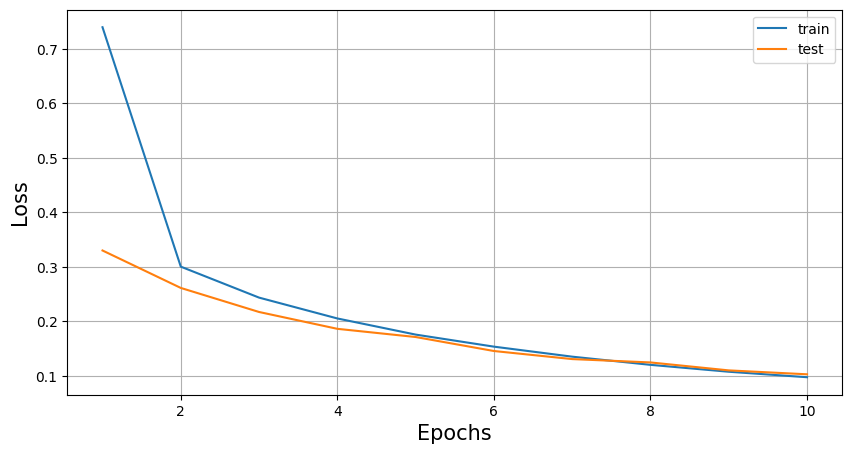

In [194]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_history["train"], label="train")
plt.plot(range(1, num_epochs + 1), loss_history["test"], label="test")
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("Loss", fontsize=15)
plt.legend()
plt.grid()
plt.show()

## Обработка результатов:

Поэтапно пропустим тестовые изображения через модель и посмотрим на размерности:

In [196]:
# get batch
imgs, labels = next(iter(testloader))
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([64, 1, 28, 28])


In [197]:
# get output
pred = model(imgs.to(device))
print("pred shape: ", pred.shape)

pred shape:  torch.Size([64, 10])


Посмотрим на результаты обработки нейронной сети для выбранного батча:

In [198]:
# First sample in prediction batch
pred[0]

tensor([ 0.1403, -0.5940,  1.3091,  5.4723, -7.6035, 11.0126, -2.1977, -6.7732,
         2.9405, -3.2005], grad_fn=<SelectBackward0>)

Чтобы посчитать вероятность, применим функццию softmax:

In [199]:
# Calculate probabilities
nn.Softmax(dim=0)(pred[0].detach())

tensor([1.8895e-05, 9.0664e-06, 6.0802e-05, 3.9083e-03, 8.1893e-09, 9.9569e-01,
        1.8237e-06, 1.8787e-08, 3.1077e-04, 6.6905e-07])

Изменим размерности данных для вывода картинок на экран:

In [200]:
# remove axis
imgs = torch.reshape(imgs, (64, 28, 28))
print("imgs shape(after reshape): ", imgs.shape)

imgs shape(after reshape):  torch.Size([64, 28, 28])


In [201]:
# take 10 first images
imgs = imgs[:10]
print("imgs shape: ", imgs.shape)

imgs shape:  torch.Size([10, 28, 28])


Посмотрим на предсказанные вероятности и выведем позицию максимального значения:

In [202]:
import numpy as np

pred = pred[:10].detach()
print("Prediction(1 sample):\n", pred[0])
digits = np.argmax(pred.cpu().numpy(), axis=1)
print("Predicted class: ", digits[0])

Prediction(1 sample):
 tensor([ 0.1403, -0.5940,  1.3091,  5.4723, -7.6035, 11.0126, -2.1977, -6.7732,
         2.9405, -3.2005])
Predicted class:  5


Визуализируем изображения, подпишем предсказанное и истинное значение:

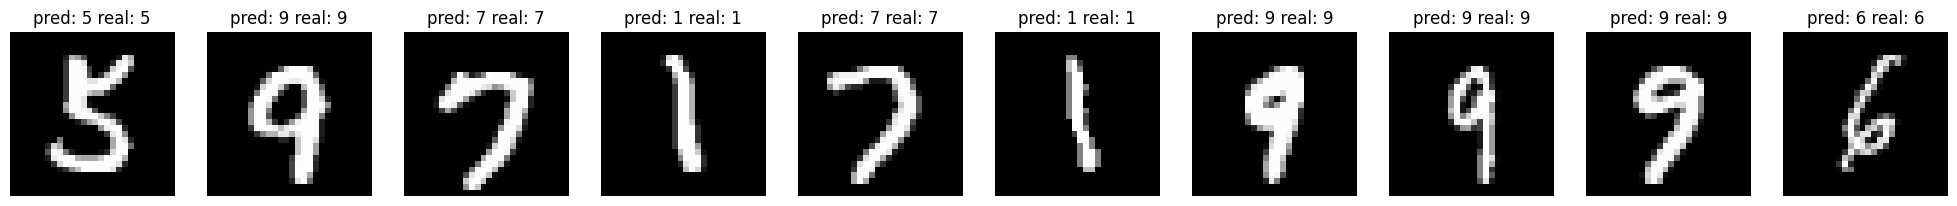

In [203]:
plt.figure(figsize=(25.0, 25.0))
for i in range(10):
    img = imgs[i]

    plt.subplot(1, 10, i + 1)
    plt.title(
        "pred: " + str(digits[i]) + " real: " + str(labels[i].numpy())
    )  # predicted and real values
    plt.axis("off")
    plt.imshow(img.numpy(), cmap="gray")

## Сохранение и загрузка весов модели

Обычно обучение модели является достаточно затратным процессом с точки зрения вычислительных ресурсов. Поэтому, однажды обучив сеть, разумно будет сохранить ее для последующего использования. Рассмотрим варианты, как это можно сделать в PyTorch.

Модели PyTorch хранят обучаемые параметры во внутреннем словаре состояния, который называется `state_dict`. Их можно сохранить с помощью метода `torch.save`.


In [204]:
torch.save(model.state_dict(), "model_weights.pth")

Для того, чтобы загрузить веса модели, сперва необходимо создать экземпляр такой модели, а затем загрузить параметры с помощью метода `load_state_dict()`.

In [205]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model_weights.pth"))
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


C:\Users\bleep\AppData\Local\Temp\ipykernel_14248\4229997318.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_weights.pth"))


In [206]:
imgs, labels = next(iter(testloader))
pred = model(torch.reshape(imgs, (64, 28, 28)).to(device))

In [207]:
pred = pred.detach()
print("Prediction(1 sample):\n", pred)
digits = np.argmax(pred.cpu().numpy(), axis=1)
print(digits)

Prediction(1 sample):
 tensor([[-4.0386e+00,  7.3574e+00, -4.9016e-01,  6.2133e-01, -2.3889e+00,
         -7.9230e-01, -2.2755e+00,  8.0882e-01,  1.5652e+00, -7.6335e-01],
        [ 1.7595e+00, -1.4622e+00,  3.7205e+00, -1.8587e+00,  2.0522e-02,
          7.2852e-01,  1.0711e+01, -8.6345e+00,  6.0726e-01, -4.4093e+00],
        [-1.5348e+00, -1.1948e+00, -2.5710e+00,  3.1388e+00, -9.2531e-01,
          5.0312e+00, -5.5775e-01, -2.5114e+00,  1.7582e+00, -1.3515e+00],
        [-3.7357e+00, -8.8949e-01, -4.3117e+00,  7.5165e+00, -5.5844e-01,
          3.7475e+00, -6.3318e+00,  9.6927e-02,  8.9101e-02,  3.6075e+00],
        [-4.8080e+00,  1.1530e+00,  6.7336e-01,  6.8110e+00, -5.6631e+00,
          1.2355e+00, -6.2321e+00,  5.2874e-01,  3.5164e+00,  1.8443e+00],
        [-1.3793e+00, -8.0639e-01,  1.0258e+01,  4.4141e+00, -3.4619e+00,
         -5.7898e+00, -3.4082e+00, -6.5126e-01,  4.8132e+00, -3.4538e+00],
        [ 2.2175e+00, -4.4422e+00,  7.7841e-01,  4.1183e+00, -5.3735e+00,
         